In [1]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS as GENSIM_STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from collections import Counter
import string
import os

d:\Anaconda\envs\NLP\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
# This is to be run if punkt and stopwords have not been downloaded
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('punkt_tab')

In [2]:
# Load and label the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

df_true['is_fake'] = 0
df_fake['is_fake'] = 1

df = pd.concat([df_true, df_fake]).reset_index(drop=True)
df.drop(columns=['date'], inplace=True)
df['original'] = df['title'] + ' ' + df['text']

In [3]:
df

,title,text,subject,is_fake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,1,McPain: John McCain Furious That Iran Treated ...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,1,How to Blow $700 Million: Al Jazeera America F...


In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    tokens = simple_preprocess(text)
    stop_words = set(stopwords.words('english')).union(GENSIM_STOPWORDS)
    return [word for word in tokens if word not in stop_words and len(word) > 3]


In [5]:
df['clean'] = df['original'].apply(preprocess)
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [7]:
df['clean']

0        [budget, fight, looms, republicans, flip, fisc...
1        [military, accept, transgender, recruits, mond...
2        [senior, republican, senator, mueller, washing...
3        [russia, probe, helped, australian, diplomat, ...
4        [trump, wants, postal, service, charge, amazon...
                               ...                        
44893    [mcpain, john, mccain, furious, iran, treated,...
44894    [justice, yahoo, settles, email, privacy, clas...
44895    [sunnistan, allied, safe, zone, plan, territor...
44896    [blow, million, jazeera, america, finally, cal...
44897    [navy, sailors, held, iranian, military, signs...
Name: clean, Length: 44898, dtype: object

In [8]:
# Tokenization and vocab
all_text = " ".join(df['clean_joined'].tolist()).split()
vocab = Counter(all_text)
vocab = {word: i + 2 for i, (word, _) in enumerate(vocab.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [9]:
def encode(text):
    return [vocab.get(word, vocab['<UNK>']) for word in text.split()]

In [10]:
df['encoded'] = df['clean_joined'].apply(encode)

In [12]:
maxlen = 500

def pad_seq(seq, maxlen):
    return seq[:maxlen] + [vocab['<PAD>']] * max(0, maxlen - len(seq))

In [13]:
df['padded'] = df['encoded'].apply(lambda x: pad_seq(x, maxlen))

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    df['padded'].tolist(), df['is_fake'].tolist(), test_size=0.2, stratify=df['is_fake']
)

In [16]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

In [17]:
train_ds = NewsDataset(x_train, y_train)
test_ds = NewsDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [21]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = self.dropout(h_n)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        
        return x.view(-1)

In [19]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [22]:
model = BiLSTMClassifier(vocab_size=len(vocab), embed_dim=128, hidden_dim=128).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping and saving
early_stop_patience = 2
best_val_loss = float('inf')
patience_counter = 0

os.makedirs("models", exist_ok=True)
model_path = "models/biltsm_fakenews.pt"

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            val_loss += criterion(outputs, batch_y).item()

    val_loss /= len(test_loader)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        patience_counter = 0
        print("Model improved. Saving model...")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stop patience triggered...")
            break

Epoch 1, Train Loss: 0.0553, Val Loss: 0.0118
Model improved. Saving model...
Epoch 2, Train Loss: 0.0078, Val Loss: 0.0057
Model improved. Saving model...
Epoch 3, Train Loss: 0.0041, Val Loss: 0.0068
Epoch 4, Train Loss: 0.0012, Val Loss: 0.0055
Model improved. Saving model...
Epoch 5, Train Loss: 0.0003, Val Loss: 0.0071
Epoch 6, Train Loss: 0.0017, Val Loss: 0.0079
Early stop patience triggered...


In [23]:
# Load best model
model.load_state_dict(torch.load(model_path))
model.eval()

# Evaluation
preds, targets = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds.extend(outputs.cpu().numpy())
        targets.extend(batch_y.numpy())

pred_labels = [1 if p > 0.5 else 0 for p in preds]

print("Accuracy: ", accuracy_score(targets, pred_labels))
print(classification_report(targets, pred_labels, target_names=["Fake", "Real"]))

C:\Users\dotyz\AppData\Local\Temp\ipykernel_6048\3297240780.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Accuracy:  0.9989977728285078
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4284
        Real       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



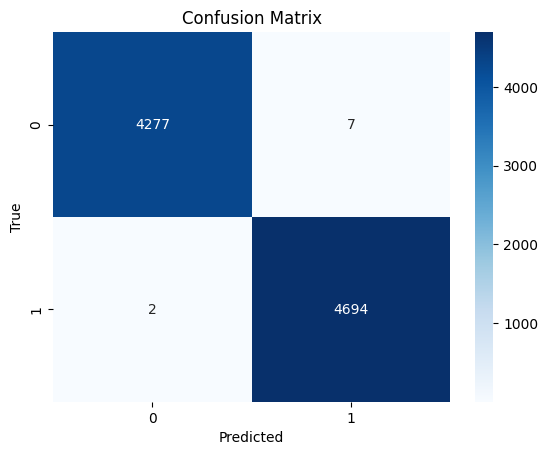

In [24]:
cm = confusion_matrix(targets, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()